In [1]:
import warnings
import xarray as xr
from matplotlib import pyplot as plt
import cmocean
import numpy as np

from pywk99.timeseries import remove_seasonal_cycle
from pywk99.timeseries import remove_linear_trend
from pywk99.filter import get_wave_filter_window
from pywk99.filter import filter_variable
from pywk99.composite import sym_lat_taper
from pywk99.composite import get_wave_composite

### Read in and preprocess the data
Test data is available here https://psl.noaa.gov/data/gridded/data.olrcdr.interp.html

In [2]:
warnings.filterwarnings("ignore", message="Converting non-nanosecond precision timedelta values to nanosecond precision")
# run data/download.ipynb to download the example data
ds = xr.open_dataset("data/olr.2xdaily.1979-2022.nc")
data = ds.sel(time=slice("1979-01", "1996-08"), lat=slice(15,-15, None))
data_normalized = data.sortby("lat")
data_normalized = remove_linear_trend(data_normalized)
data_normalized = remove_seasonal_cycle(data_normalized)
data_normalized = sym_lat_taper(data_normalized, zero_crossing=15.)

### Get filtered Kelvin wave data

In [3]:
# Define Kelvin wave filter window
wave_type = "kelvin"
w_min, w_max = (0.075, 0.3)     # Frequencies
k_min, k_max = (1, 10)          # Zonal wavenumbers
h_min, h_max = (5, 90)          # Equivalent depths
filter_window = get_wave_filter_window(
    wave_type, k_min, k_max, w_min, w_max, h_min, h_max
    )

# Filter the data
filtered_data = filter_variable(data_normalized["olr"], filter_window)
filtered_data = filtered_data.rename({"kelvin": "olr_kelvin"})

### Build the Kelvin wave composite

In [4]:
detection_Ndays = 60    #length of windows for which wave events should be identified [days]
difference_Ndays = 30   #length between two wave events to be considered [days]
composite_Ndays = 20    #length of a composite [days]

composite = get_wave_composite(
    filtered_data, 'olr_kelvin', composite_Ndays, detection_Ndays, difference_Ndays
    )

### Plot spacial structure of composited Kelvin wave

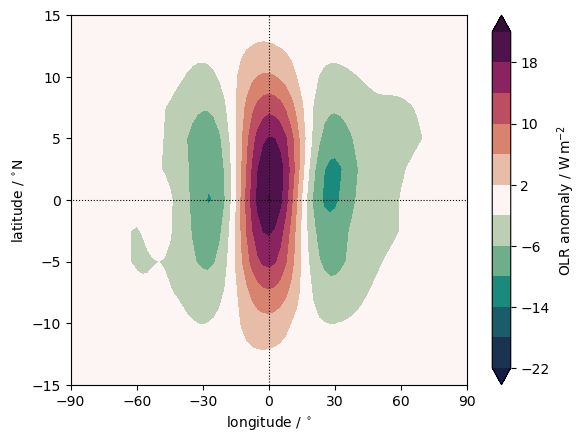

In [5]:
plot = plt.contourf(
    composite['lon'], composite['lat'], composite['olr_kelvin'].sel(
        time=np.timedelta64(0, "D")).transpose(),
    cmap=cmocean.cm.curl, levels=np.arange(-22, 23, 4), extend='both')
plt.colorbar(plot, label=r'OLR anomaly / W$\,$m$^{-2}$')
plt.xlim([-90, 90])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel(r'longitude / $^{\circ}$')
plt.ylabel(r'latitude / $^{\circ}$N')
plt.vlines(x=0, ymin=-15, ymax=15, color='k', ls=':', lw=0.8)
plt.hlines(y=0, xmin=-180, xmax=180, color='k', ls=':', lw=0.8)

### Plot spatiotemporal structure of composited Kelvin wave

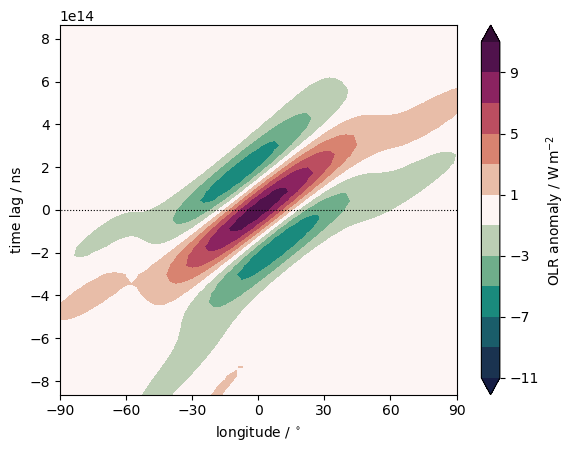

In [6]:
plot = plt.contourf(
    composite['lon'], composite['time'], composite['olr_kelvin'].mean(dim="lat"),
    cmap=cmocean.cm.curl, levels=np.arange(-11, 12, 2), extend='both')
plt.colorbar(plot, label=r'OLR anomaly / W$\,$m$^{-2}$')
plt.xlim([-90, 90])
plt.xticks(np.arange(-90, 91, 30))
plt.ylim([np.timedelta64(-10, "D")/np.timedelta64(1, "ns"),
          np.timedelta64(10, "D")/np.timedelta64(1, "ns")])
plt.xlabel(r'longitude / $^{\circ}$')
plt.ylabel(r'time lag / ns')
plt.hlines(y=0, xmin=-180, xmax=180, color='k', ls=':', lw=0.8)